In [ ]:
import warnings
import os
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, Flatten, LSTM, Dense, Dropout, BatchNormalization, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Suppress specific warnings
warnings.filterwarnings('ignore', message='SymbolDatabase.GetPrototype() is deprecated.')

# Set the base directory for videos
base_dir = r'C:\Users\admin\Downloads\tanuja\nturgbd_rgb_s001 - Copy\nturgb+d_rgb\training'

# Action names
action_names = ["drink water", "eat meal", "brush teeth", "brush hair", "drop",
"pick up", "throw", "sit down", "stand up", "clapping",
"reading", "writing", "tear up paper", "put on jacket", "take off jacket",
"put on a shoe", "take off a shoe", "put on glasses", "take off glasses",
"put on a hat or cap", "take off a hat or cap", "cheer up", "hand waving",
"kicking something", "reach into pocket", "hopping", "jump up",
"phone call", "play with phone or tablet", "type on a keyboard",
"point to something", "taking a selfie", "check time (from watch)",
"rub two hands", "nod head or bow", "shake head", "wipe face",
"salute", "put palms together", "cross hands in front", "sneeze or cough",
"staggering", "falling down", "headache", "chest pain", "back pain",
"neck pain", "nausea or vomiting", "fan self", "punch or slap",
"kicking", "pushing"]

# Map labels to numeric values
label_map = {name: i for i, name in enumerate(action_names)}

# Function to get all video paths and their labels
def get_video_paths_and_labels(base_dir):
    video_paths = []
    labels = []
    for action in os.listdir(base_dir):
        action_dir = os.path.join(base_dir, action)
        if os.path.isdir(action_dir):
            for video in os.listdir(action_dir):
                if video.endswith(".avi"):
                    video_paths.append(os.path.join(action_dir, video))
                    labels.append(action)
    return video_paths, labels

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# Function to perform pose detection and return annotated frame and landmarks
def detect_pose(frame, pose_video):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose_video.process(frame_rgb)
    if results.pose_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(frame, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS)
    return frame, results

# Function to analyze the results and get coordinates of each landmark
def get_landmark_coordinates(results):
    if not results.pose_landmarks:
        return []
    landmarks = []
    for lm in results.pose_landmarks.landmark:
        landmarks.append((lm.x, lm.y, lm.z))
    return landmarks

# Function to process video, extract frames, perform pose estimation, and collect results
def process_video(video_path, skip_frames=5):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video file.")
        return []

    frame_number = 0
    all_coordinates = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_number % skip_frames == 0:
            # Perform pose detection
            _, results = detect_pose(frame, pose_video)
            coordinates = get_landmark_coordinates(results)

            # Store the coordinates
            if coordinates:
                all_coordinates.append(coordinates)

        frame_number += 1

    cap.release()
    return all_coordinates

# Function to preprocess data
def preprocess_data(all_coordinates_array, all_labels_array, sequence_length, num_joints):
    sequences = []
    labels = []
    for i in range(len(all_coordinates_array) - sequence_length + 1):
        frame_sequence = np.array(all_coordinates_array[i:i + sequence_length])
        sequences.append(frame_sequence.reshape((sequence_length, num_joints, 3)))  # 3 coordinates (x, y, z)
        labels.append(label_map[all_labels_array[i]])
    sequences = np.array(sequences)
    labels = to_categorical(labels, num_classes=len(action_names))
    return sequences, labels

# Function to build the CNN-LSTM model
def build_model(num_joints, num_classes, sequence_length):
    model = Sequential()
    model.add(Input(shape=(sequence_length, num_joints, 3)))  # Input layer
    model.add(TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=False))  # Adjust LSTM units as needed
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


Epoch 1/50
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - accuracy: 0.3047 - loss: 2.5681 - val_accuracy: 0.6537 - val_loss: 1.1257
Epoch 2/50
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.7224 - loss: 0.9328 - val_accuracy: 0.8101 - val_loss: 0.6401
Epoch 3/50
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.8486 - loss: 0.5258 - val_accuracy: 0.8851 - val_loss: 0.3954
Epoch 4/50
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9110 - loss: 0.3269 - val_accuracy: 0.8752 - val_loss: 0.3928
Epoch 5/50
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9381 - loss: 0.2327 - val_accuracy: 0.9450 - val_loss: 0.2047
Epoch 6/50
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9571 - loss: 0.1690 - val_accuracy: 0.9501 - val_loss: 0.1736
Epoch 7/50
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9670 - loss: 0.1315 - val_accuracy: 0.9357 - val_loss: 0.2030
Epoch 8/50
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9724 -

462/462 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
                           precision    recall  f1-score   support

              drink water       0.99      1.00      0.99       293
                 eat meal       0.99      0.98      0.99       332
              brush teeth       1.00      1.00      1.00       310
               brush hair       1.00      1.00      1.00       342
                     drop       0.98      1.00      0.99       216
                  pick up       1.00      1.00      1.00       281
                    throw       1.00      1.00      1.00       257
                 sit down       0.99      0.99      0.99       289
                 stand up       0.99      0.99      0.99       233
                 clapping       1.00      0.99      0.99       240
                  reading       1.00      0.95      0.97       345
                  writing       0.96      1.00      0.98       324
            tear up paper       1.00      0.97      0.98       294
            put on j

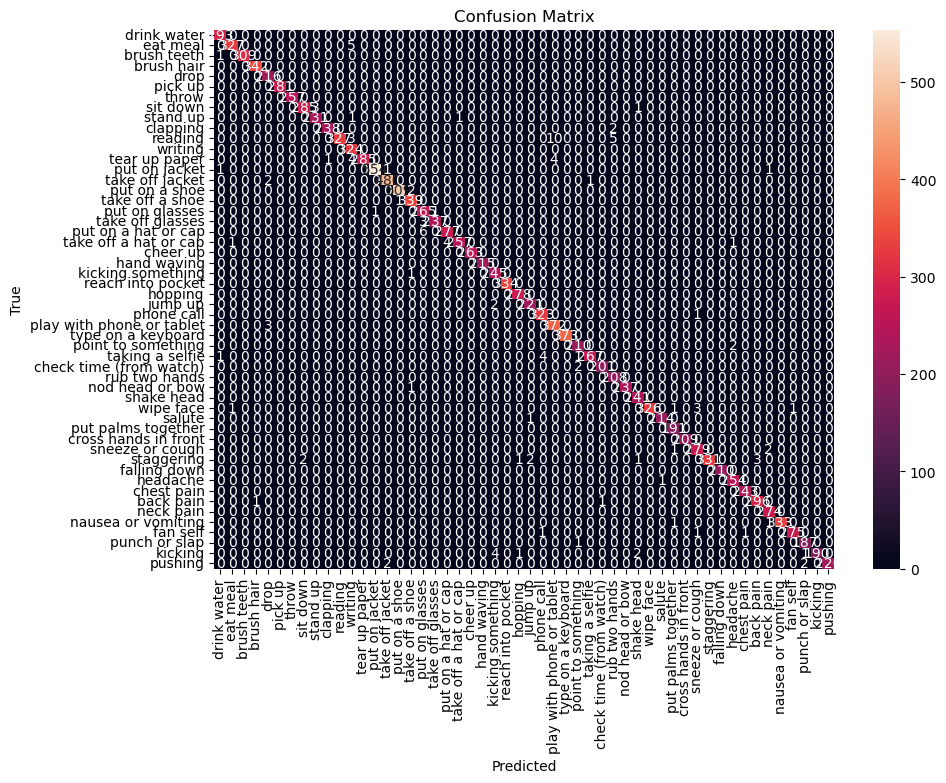

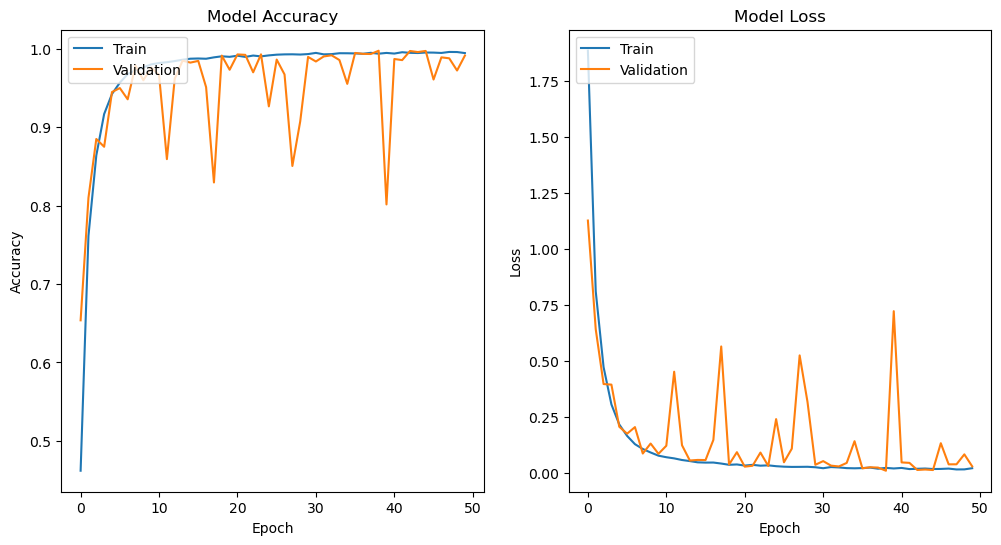

In [ ]:
# Get video paths and labels
video_paths, labels = get_video_paths_and_labels(base_dir)
all_coordinates_array = []
all_labels_array = []

# Process each video to extract pose landmarks
for video_path, label in zip(video_paths, labels):
    coordinates = process_video(video_path, skip_frames=3)
    if coordinates:
        all_coordinates_array.extend(coordinates)
        all_labels_array.extend([label] * len(coordinates))

num_joints = 33  # Number of landmarks detected by MediaPipe Pose
sequence_length = 30  # Number of frames to consider in a sequence

# Preprocess data
if len(all_coordinates_array) > sequence_length:
    sequences, labels = preprocess_data(all_coordinates_array, all_labels_array, sequence_length, num_joints)

    # Build the model
    model = build_model(num_joints, len(action_names), sequence_length)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

    # Save the model
    model.save("activity_recognition_model.keras")

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Print classification report
    print(classification_report(y_true, y_pred_classes, target_names=action_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=action_names, yticklabels=action_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
else:
    print("Error: Not enough data to generate sequences. Ensure you have enough frames and proper input format.")


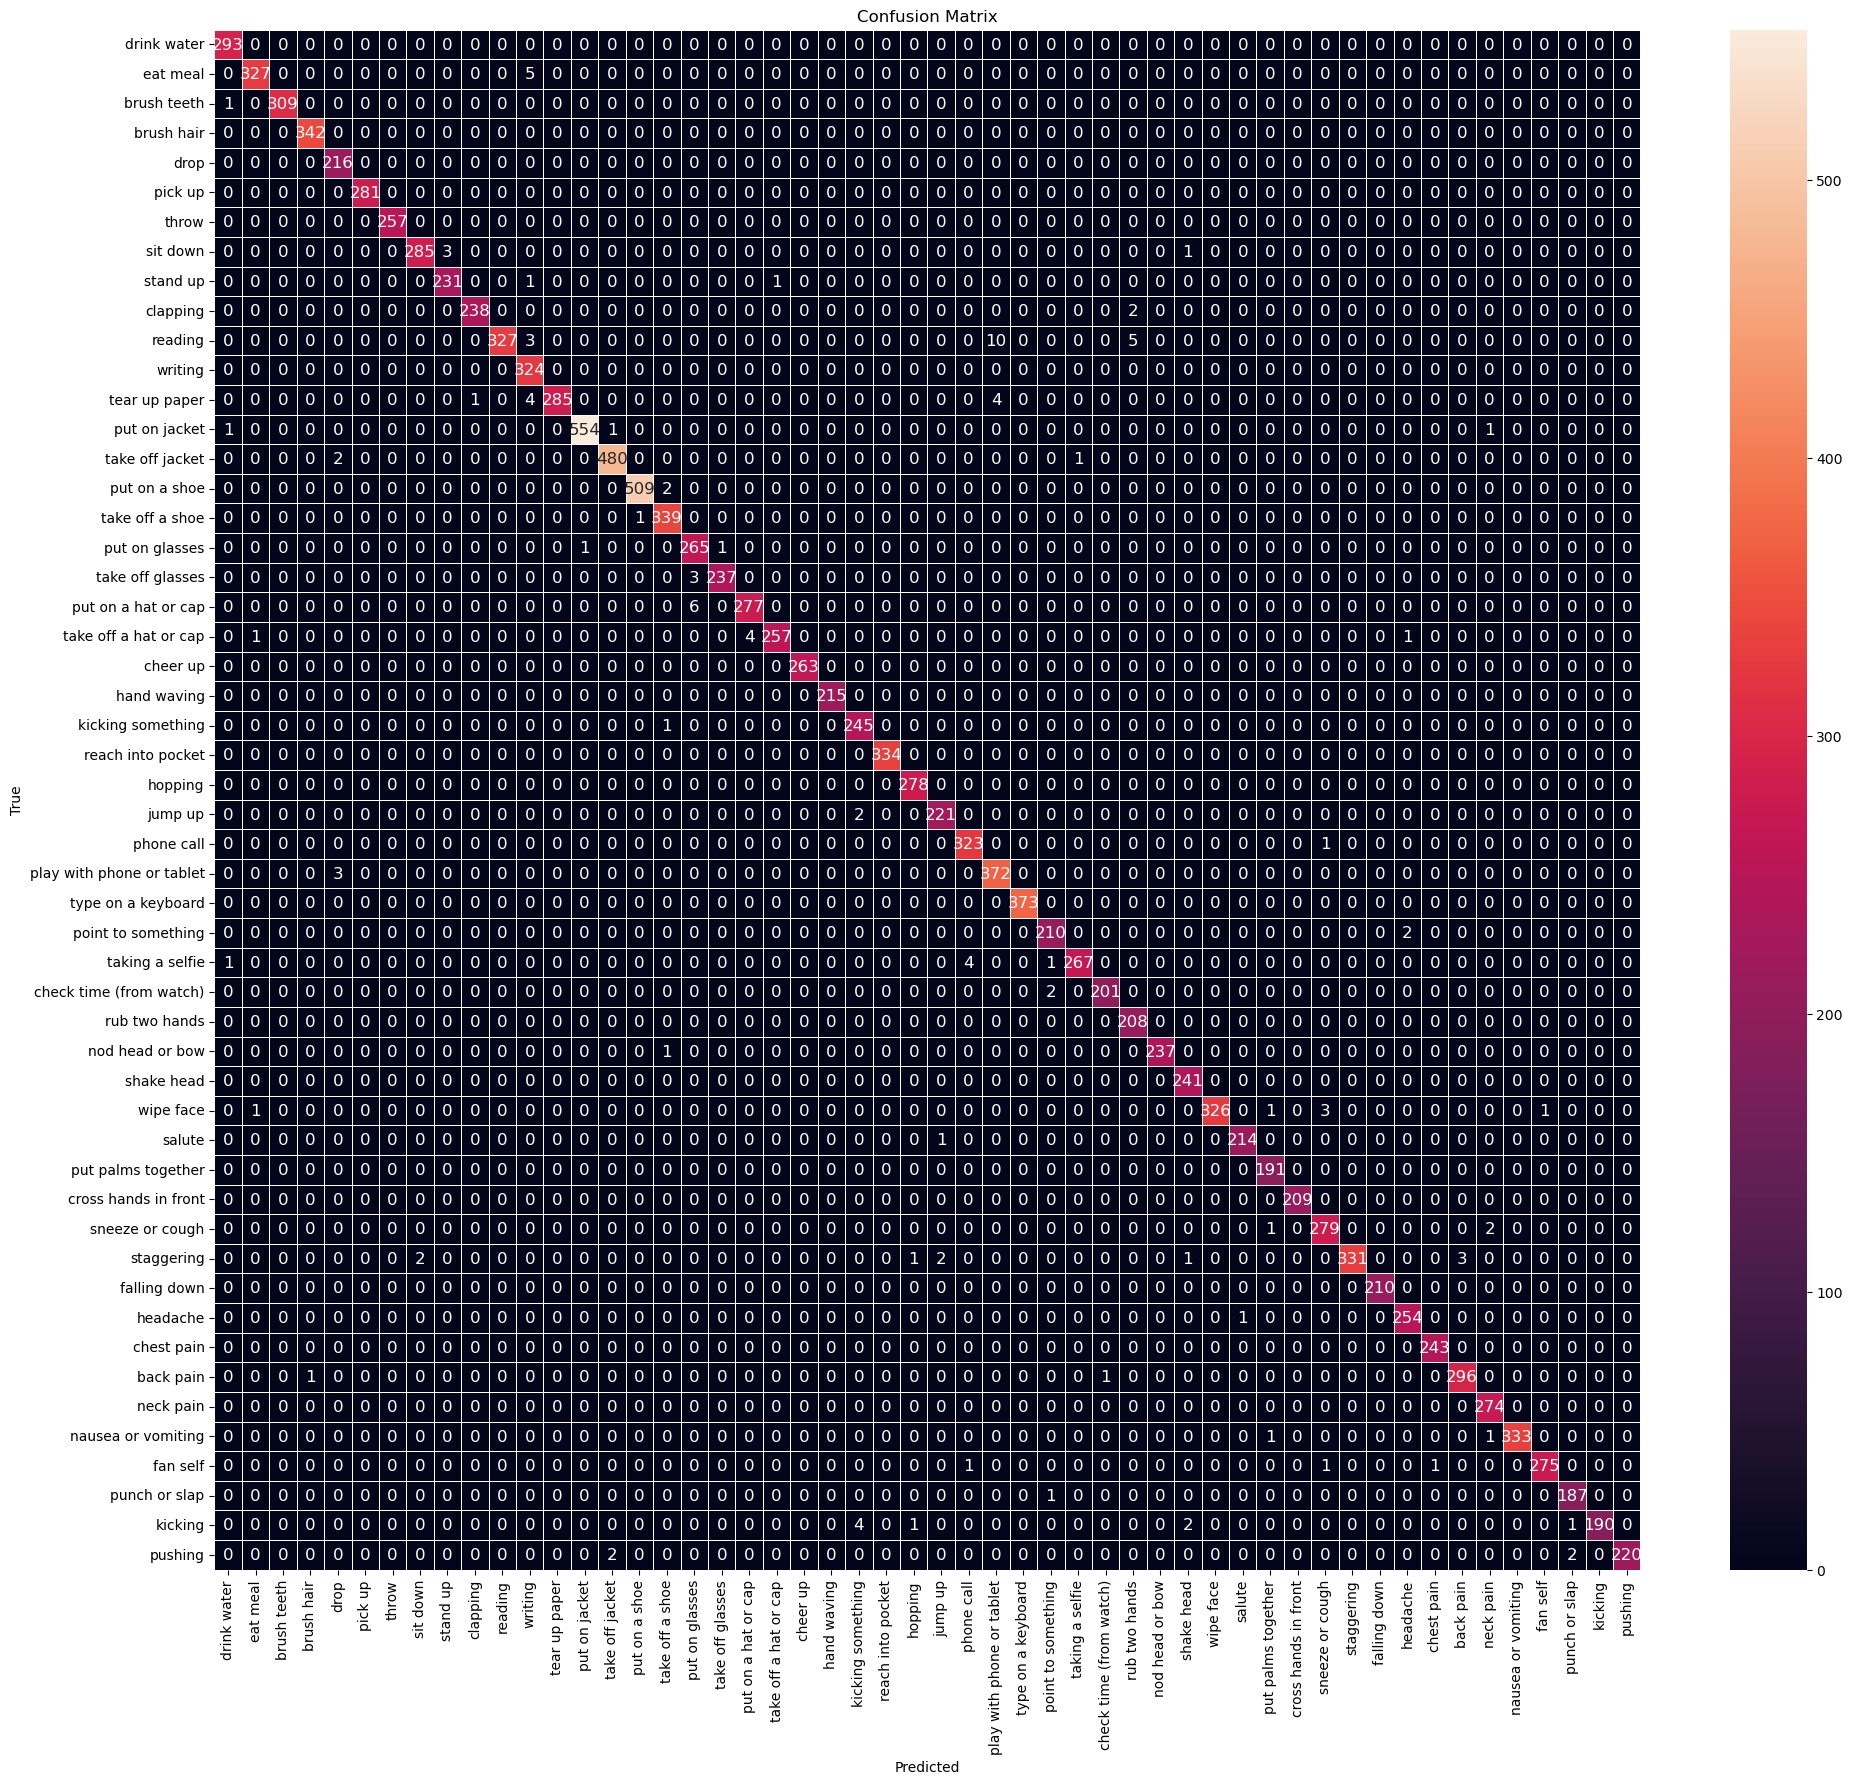

<Figure size 640x480 with 0 Axes>

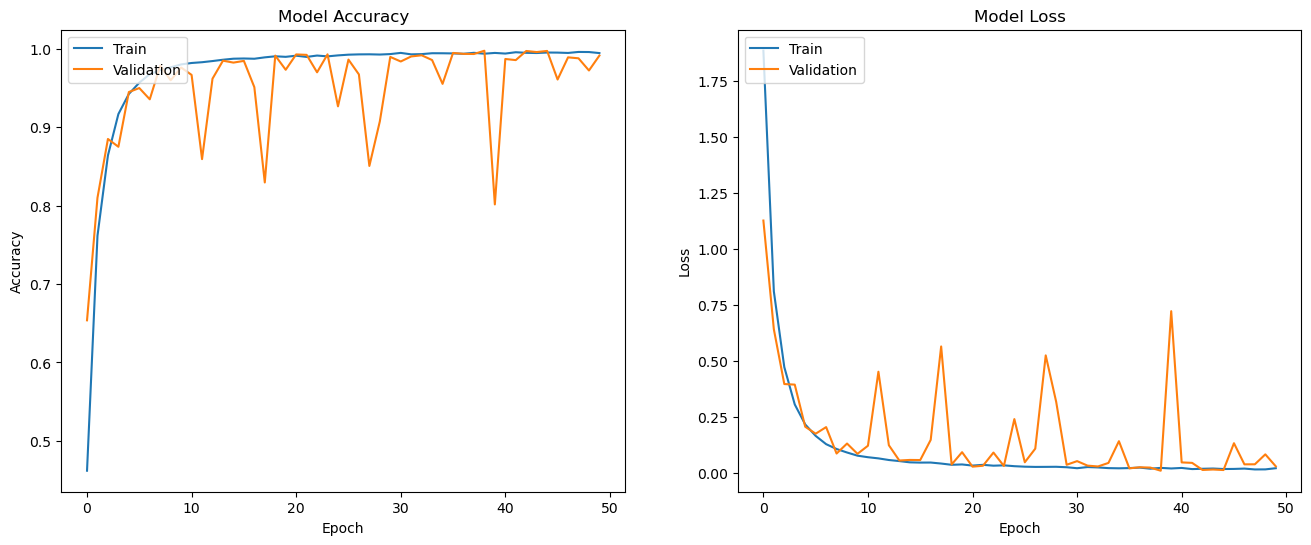

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'history' contains your training history with accuracy and loss

# Filter accuracy and loss values
epochs = len(history.history['accuracy'])
filtered_epochs = [i for i in range(epochs) if history.history['accuracy'][i] >= 0.88 and history.history['val_loss'][i] <= 0.01]

if filtered_epochs:  # Check if there are epochs left after filtering
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(23, 20))  # Increase figure size here
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=action_names, yticklabels=action_names, linewidths=.5, annot_kws={"size": 12})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    plt.savefig('confusion_matrix.png', bbox_inches='tight')
    plt.show()

    # Plot training & validation accuracy values
    plt.figure(figsize=(16, 6))  # Increase figure size here
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
else:
    print("Error: Not enough data to generate sequences. Ensure you have enough frames and proper input format.")
